Importing Libs

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Reading Dataset using keras

In [104]:
path = "../Dataset/BinDataset"
batch_size = 16
# images height and width
img_height = 64
img_width = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 43405 files belonging to 2 classes.
Using 34724 files for training.


In [105]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 43405 files belonging to 2 classes.
Using 8681 files for validation.


In [106]:
class_names = train_ds.class_names
print("train_ds class_names: ", train_ds.class_names)
print("val_ds class_names: ", val_ds.class_names)

train_ds class_names:  ['NotSuspicious', 'Suspicious']
val_ds class_names:  ['NotSuspicious', 'Suspicious']


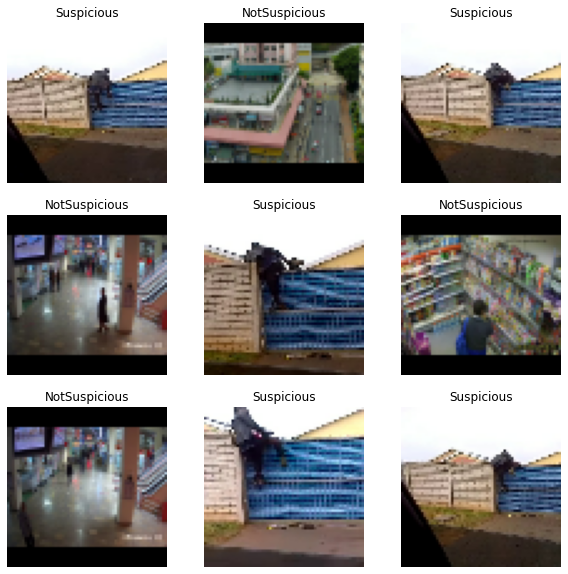

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [108]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Below is a time taking process it gets image shaoe and labels shape

In [109]:
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

Reducing the pixel values to the range of 0 to 1

In [110]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.2),  
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.2),
  # layers.Dense(num_classes,activation='relu'),
  layers.Dense(1,activation='sigmoid')
  # layers.Dense(1)
])

In [ ]:
# model.compile(optimizer='adam',
#               loss=keras.losses.binary_crossentropy,
#               metrics=['accuracy'])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
            #   loss='binary_crossentropy',
              metrics=['binary_crossentropy','accuracy']
              )

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  shuffle=True,
  batch_size=batch_size,
  epochs=epochs,
  use_multiprocessing=True
)

Epoch 1/10
543/543 [==============================] - 64s 116ms/step - loss: 0.1504 - binary_crossentropy: 0.6408 - accuracy: 0.9145 - val_loss: 0.0153 - val_binary_crossentropy: 0.0431 - val_accuracy: 0.9888
Epoch 2/10
543/543 [==============================] - 65s 120ms/step - loss: 0.0494 - binary_crossentropy: 0.1151 - accuracy: 0.9693 - val_loss: 0.0085 - val_binary_crossentropy: 0.0276 - val_accuracy: 0.9977
Epoch 3/10
543/543 [==============================] - 63s 117ms/step - loss: 0.0422 - binary_crossentropy: 0.1071 - accuracy: 0.9719 - val_loss: 0.0058 - val_binary_crossentropy: 0.0220 - val_accuracy: 0.9982
Epoch 4/10
543/543 [==============================] - 64s 119ms/step - loss: 0.0363 - binary_crossentropy: 0.0872 - accuracy: 0.9753 - val_loss: 0.0061 - val_binary_crossentropy: 0.0251 - val_accuracy: 0.9983
Epoch 5/10
543/543 [==============================] - 64s 117ms/step - loss: 0.0346 - binary_crossentropy: 0.0815 - accuracy: 0.9747 - val_loss: 0.0051 - val_binary

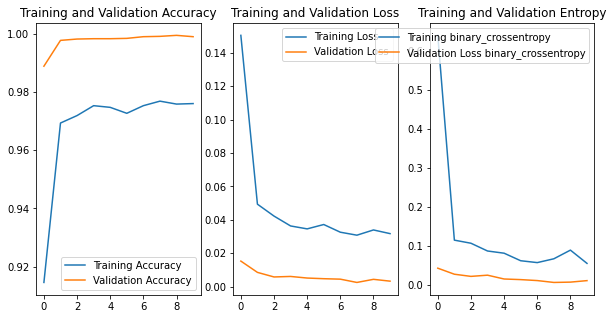

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

binary_crossentropy = history.history['binary_crossentropy']
val_binary_crossentropy = history.history['val_binary_crossentropy']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, binary_crossentropy, label='Training binary_crossentropy')
plt.plot(epochs_range, val_binary_crossentropy, label='Validation Loss binary_crossentropy')
plt.legend(loc='upper right')
plt.title('Training and Validation Entropy')





plt.show()

In [ ]:
import sklearn.metrics as metrics
model.evaluate(val_ds)



136/136 [==============================] - 5s 38ms/step - loss: 0.6945 - binary_crossentropy: 0.6945 - accuracy: 0.3807


[0.6945192217826843, 0.6945192217826843, 0.3807165026664734]

In [ ]:
preds = model.predict(val_ds,
verbose=1)
print(preds)
print(train_ds.class_names)
fpr, tpr, _ = metrics.roc_curve(val_ds.class_names, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

136/136 [==============================] - 5s 39ms/step
[[0.49470118]
 [0.49727502]
 [0.5006419 ]
 ...
 [0.4983416 ]
 [0.5003104 ]
 [0.50404704]]
['NotSuspicious', 'Suspicious']


ValueError: Found input variables with inconsistent numbers of samples: [2, 8681]

In [ ]:
test_image_path =  "../Dataset\BinDataset\Suspicious\Shooting002_x264_100.png"
# "../Dataset/BinDataset/NotSuspicious/Normal_Videos_944_x264_7110.png"
# "../testing_data/mtext.jpg"

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
classes = predictions.argmax(axis=-1)
score = tf.nn.sigmoid(predictions)

print(classes)
print(predictions)

class_index = predictions[0][0] > 0.5 and 1 or 0

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[class_index], 100 * np.max(score))
)

[0]
[[0.49650618]]
This image most likely belongs to NotSuspicious with a 62.16 percent confidence.


In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('../trained_model/my_model.h5')

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('../trained_model/my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)       